In [169]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flood-prediction-factors/flood.csv


In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [171]:
df=pd.read_csv("/kaggle/input/flood-prediction-factors/flood.csv")

# Exploratory data analysis
We see below that there are no nan values above there so there is no need to remove them. We don't find a lot of interesting components so it just makes sense the scale it (between 0 and 1) since models prefer scaled values. 

In [172]:
df.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475


In [173]:
df.shape

(50000, 21)

In [174]:
df.isna().sum()

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

# Creating the model

In [175]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score

In [176]:
class FloodingPredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FloodingPredictionModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.05)
        self.layer2 = nn.Linear(hidden_size, hidden_size // 2)
        self.output_layer = nn.Linear(hidden_size // 2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

    def fit(self, x_train, y_train, epochs, learning_rate):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        # Ensure that x_train and y_train are properly converted to tensors
        x_train = torch.tensor(x_train.values, dtype=torch.float32)
        y_train = torch.tensor(y_train.values, dtype=torch.float32) 

        # Verify the dimensions here
        print("x_train shape:", x_train.shape)  # Should be (40000, 20)
        print("y_train shape:", y_train.shape)  # Should be (40000,)
        
        for epoch in range(epochs):
            self.train()
            optimizer.zero_grad()
            outputs = self(x_train).squeeze()
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

    def predict(self, x_test):
        x_test = torch.tensor(x_test.values, dtype=torch.float32)
        self.eval()
        with torch.no_grad():
            outputs = self(x_test)
        return outputs.numpy()

    def score(self, x_test, y_test):
        y_pred = self.predict(x_test)
        return roc_auc_score(y_test, y_pred)

# Usage
input_size = 20
hidden_size = 128
output_size = 1

model = FloodingPredictionModel(input_size, hidden_size, output_size)


# Training the model

In [177]:
y = df['FloodProbability']
X = df.drop(['FloodProbability'], axis = 1)


In [178]:
X.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,3,8,6,6,4,4,6,2,3,2,5,10,7,4,2,3,4,3,2,6
1,8,4,5,7,7,9,1,5,5,4,6,9,2,6,2,1,1,9,1,3
2,3,10,4,1,7,5,4,7,4,9,2,7,4,4,8,6,1,8,3,6
3,4,4,2,7,3,4,1,4,6,4,9,4,2,6,6,8,8,6,6,10
4,3,7,5,2,5,8,5,2,7,5,7,7,6,5,3,3,4,4,3,4


In [188]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(X)

X = pd.DataFrame(scaled_data, columns=X.columns)

# Show the first few rows of the scaled DataFrame
X.head()


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,0.1875,0.444444,0.3750,0.352941,0.235294,0.235294,0.3750,0.1250,0.1875,0.111111,0.3125,0.588235,0.411765,0.2500,0.1250,0.176471,0.210526,0.136364,0.1250,0.3750
1,0.5000,0.222222,0.3125,0.411765,0.411765,0.529412,0.0625,0.3125,0.3125,0.222222,0.3750,0.529412,0.117647,0.3750,0.1250,0.058824,0.052632,0.409091,0.0625,0.1875
2,0.1875,0.555556,0.2500,0.058824,0.411765,0.294118,0.2500,0.4375,0.2500,0.500000,0.1250,0.411765,0.235294,0.2500,0.5000,0.352941,0.052632,0.363636,0.1875,0.3750
3,0.2500,0.222222,0.1250,0.411765,0.176471,0.235294,0.0625,0.2500,0.3750,0.222222,0.5625,0.235294,0.117647,0.3750,0.3750,0.470588,0.421053,0.272727,0.3750,0.6250
4,0.1875,0.388889,0.3125,0.117647,0.294118,0.470588,0.3125,0.1250,0.4375,0.277778,0.4375,0.411765,0.352941,0.3125,0.1875,0.176471,0.210526,0.181818,0.1875,0.2500


In [189]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [190]:
y_train

48244    0.490
31245    0.510
44165    0.510
10820    0.555
27731    0.535
         ...  
30140    0.580
18889    0.455
12551    0.430
47852    0.445
15054    0.485
Name: FloodProbability, Length: 40000, dtype: float64

In [191]:
# Here, x_train and y_train should be your training data loaded as numpy arrays or similar.
model.fit(x_train, y_train, epochs=2000, learning_rate=0.001)
predictions = model.predict(x_test)

x_train shape: torch.Size([40000, 20])
y_train shape: torch.Size([40000])
Epoch 1/2000, Loss: 0.877251386642456
Epoch 2/2000, Loss: 0.8611401319503784
Epoch 3/2000, Loss: 0.8455895781517029
Epoch 4/2000, Loss: 0.8309119343757629
Epoch 5/2000, Loss: 0.8171417713165283
Epoch 6/2000, Loss: 0.804160475730896
Epoch 7/2000, Loss: 0.7917206287384033
Epoch 8/2000, Loss: 0.7800397872924805
Epoch 9/2000, Loss: 0.7688575387001038
Epoch 10/2000, Loss: 0.7583134770393372
Epoch 11/2000, Loss: 0.748304009437561
Epoch 12/2000, Loss: 0.7389014363288879
Epoch 13/2000, Loss: 0.7301628589630127
Epoch 14/2000, Loss: 0.7221046686172485
Epoch 15/2000, Loss: 0.71474289894104
Epoch 16/2000, Loss: 0.7084117531776428
Epoch 17/2000, Loss: 0.7030284404754639
Epoch 18/2000, Loss: 0.6986932754516602
Epoch 19/2000, Loss: 0.6954853534698486
Epoch 20/2000, Loss: 0.6933954358100891
Epoch 21/2000, Loss: 0.6924103498458862
Epoch 22/2000, Loss: 0.6925050020217896
Epoch 23/2000, Loss: 0.6933737993240356
Epoch 24/2000, Loss:

# Observing and concluding findings

We see that the model is very good with great continuous model values for the MAE, MSE and R2 metrics.

In [192]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(mean_absolute_error(y_test, predictions))
print(mean_squared_error(y_test, predictions))
print(r2_score(y_test, predictions))

0.0009442939623594263
1.7172114024709951e-06
0.9993032311078375


In [193]:
predictions[:10]

array([[0.58439934],
       [0.47997174],
       [0.57448155],
       [0.5398421 ],
       [0.46194088],
       [0.48463374],
       [0.4855781 ],
       [0.50528914],
       [0.4229717 ],
       [0.53514004]], dtype=float32)

In [194]:
y_test[:10]

35704    0.585
4427     0.480
2178     0.575
4756     0.540
10484    0.460
41736    0.485
46444    0.485
23958    0.505
8762     0.420
12359    0.535
Name: FloodProbability, dtype: float64

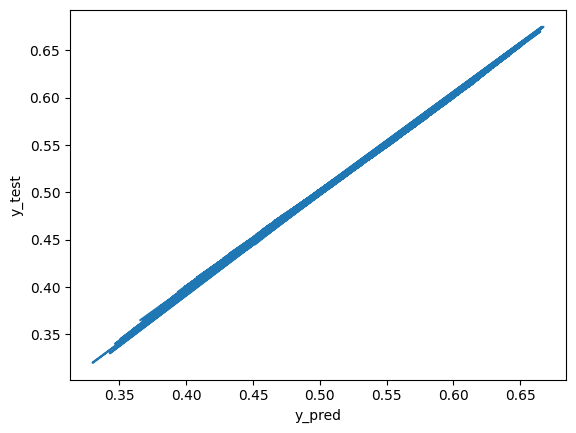

In [195]:

import matplotlib.pyplot as plt
plt.plot(predictions, y_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()